In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import torch


2024-11-16 19:24:10.246363: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 19:24:11.731854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-16 19:24:15.603192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import cv2
import numpy as np

def video_to_tensor(video_path):
    # Открываем видео с помощью OpenCV
    cap = cv2.VideoCapture(video_path)

    # Получаем информацию о видео
    fps = cap.get(cv2.CAP_PROP_FPS)  # Частота кадров
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Общее количество кадров
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Высота кадра
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Ширина кадра

    print(f"FPS: {fps}, Total frames: {total_frames}, Frame size: {frame_width}x{frame_height}")

    # Считываем кадры и создаем тензор
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Если кадры закончились

        # Преобразуем кадр в черно-белый (грейскейл)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Добавляем размер канала (1) для совместимости с другими форматами (H, W, C)
        frame_gray = np.expand_dims(frame_gray, axis=-1)

        # Добавляем кадр в список
        frames.append(frame_gray)

    # Закрываем видео
    cap.release()

    # Преобразуем список в NumPy массив (тензор)
    video_tensor = np.array(frames)

    # Формат тензора: (Количество кадров, Высота, Ширина, Каналы)
    print(video_tensor.shape)
    video_tensor = np.swapaxes(video_tensor, 1, 3)
    video_tensor = np.swapaxes(video_tensor, 2, 3)
    print(f"Video tensor shape: {video_tensor.shape}")
    return torch.from_numpy(video_tensor)

# Пример использования
video_path = 'person15_running_d1_uncomp.avi'  # Укажи путь к твоему видео
video_tensor = video_to_tensor(video_path)

# Выведем размер тензора
print(f"Tensor shape: {video_tensor.shape}")


FPS: 30.0, Total frames: 234, Frame size: 852x480
(234, 480, 852, 1)
Video tensor shape: (234, 1, 480, 852)
Tensor shape: torch.Size([234, 1, 480, 852])


In [ ]:
import cv2
import numpy as np
import torch

def video_to_tensor(video_path, new_width=64, new_height=64):
    """
    Преобразуем видео в тензор, с возможностью уменьшения разрешения.
    """
    # Открываем видео с помощью OpenCV
    cap = cv2.VideoCapture(video_path)

    # Получаем информацию о видео
    fps = cap.get(cv2.CAP_PROP_FPS)  # Частота кадров
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Общее количество кадров
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Высота кадра
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Ширина кадра

    print(f"FPS: {fps}, Total frames: {total_frames}, Original size: {frame_width}x{frame_height}")

    # Считываем кадры и создаем тензор
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Если кадры закончились

        # Преобразуем кадр в черно-белый (грейскейл)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Изменяем размер кадра до заданных (new_width, new_height)
        resized_frame = cv2.resize(frame_gray, (new_width, new_height))

        # Добавляем размер канала (1) для совместимости с другими форматами (H, W, C)
        resized_frame = np.expand_dims(resized_frame, axis=-1)

        # Добавляем кадр в список
        frames.append(resized_frame)

    # Закрываем видео
    cap.release()

    # Преобразуем список в NumPy массив (тензор)
    video_tensor = np.array(frames)

    # Формат тензора: (Frames, Channels, Height, Width)
    print(f"Video tensor shape before swap: {video_tensor.shape}")
    video_tensor = np.swapaxes(video_tensor, 1, 3)  # (Frames, Height, Width, Channels) -> (Frames, Channels, Height, Width)
    video_tensor = np.swapaxes(video_tensor, 2, 3)
    print(f"Video tensor shape after swap: {video_tensor.shape}")

    return video_tensor



# Пример использования
video_paths = [
    'person15_running_d1_uncomp.avi',
]

# Формат: (num_videos, frames, channels, height, width)


def create_dataset(video_paths, new_width=64, new_height=64):
    """
    Создаёт датасет из списка видеофайлов.
    """
    video_tensors = []

    for path in video_paths:
        print(f"Processing video: {path}")
        video_tensor = video_to_tensor(path, new_width, new_height)
        video_tensors.append(video_tensor)

    # Собираем все видео в один тензор (формат: [num_videos, frames, channels, height, width])
    dataset = np.stack(video_tensors)
    print(f"Dataset shape: {dataset.shape}")

    # Конвертируем в тензор PyTorch
    return torch.from_numpy(dataset)

In [ ]:
dataset = create_dataset(video_paths, new_width=160, new_height=120)

Processing video: person15_running_d1_uncomp.avi
FPS: 30.0, Total frames: 234, Original size: 852x480
Video tensor shape before swap: (234, 120, 160, 1)
Video tensor shape after swap: (234, 1, 120, 160)
Dataset shape: (1, 234, 1, 120, 160)


In [ ]:
def val_data(dataset, val_size = 0.9):
    indexes = np.arange(dataset.shape[0])

    x_train_ind = indexes[: int(val_size * dataset.shape[0])]
    y_train_ind = indexes[1: int(val_size * dataset.shape[0]) + 1]

    x_test_ind = indexes[int(val_size * dataset.shape[0]) + 1: -1] #Здесь последний не берётся
    y_test_ind = indexes[int(val_size * dataset.shape[0]) + 2:] #Здесь берётся
    return dataset[x_train_ind] / 255 , dataset[y_train_ind] / 255, dataset[x_test_ind] / 255, dataset[y_test_ind] / 255

x_train, y_train, x_test, y_test = val_data(dataset[0], 0.9)

x_train = np.expand_dims(x_train, axis=0)
y_train = np.expand_dims(y_train, axis=0)
x_test = np.expand_dims(x_test, axis=0)
y_test = np.expand_dims(y_test, axis=0)
def swapax(x):
    inp = np.swapaxes(x, 2, 4)
    inp = np.swapaxes(inp, 2,3)
    print("New Shapes: " + str(inp.shape))
    return inp
x_train = swapax(x_train)
y_train = swapax(y_train)
x_test = swapax(x_test)
y_test = swapax(y_test)

#(batch_num, frames, channels, height, weight)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Test Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

New Shapes: (1, 210, 120, 160, 1)
New Shapes: (1, 210, 120, 160, 1)
New Shapes: (1, 22, 120, 160, 1)
New Shapes: (1, 22, 120, 160, 1)
Training Dataset Shapes: (1, 210, 120, 160, 1), (1, 210, 120, 160, 1)
Test Dataset Shapes: (1, 22, 120, 160, 1), (1, 22, 120, 160, 1)


Displaying frames from 31 to 110


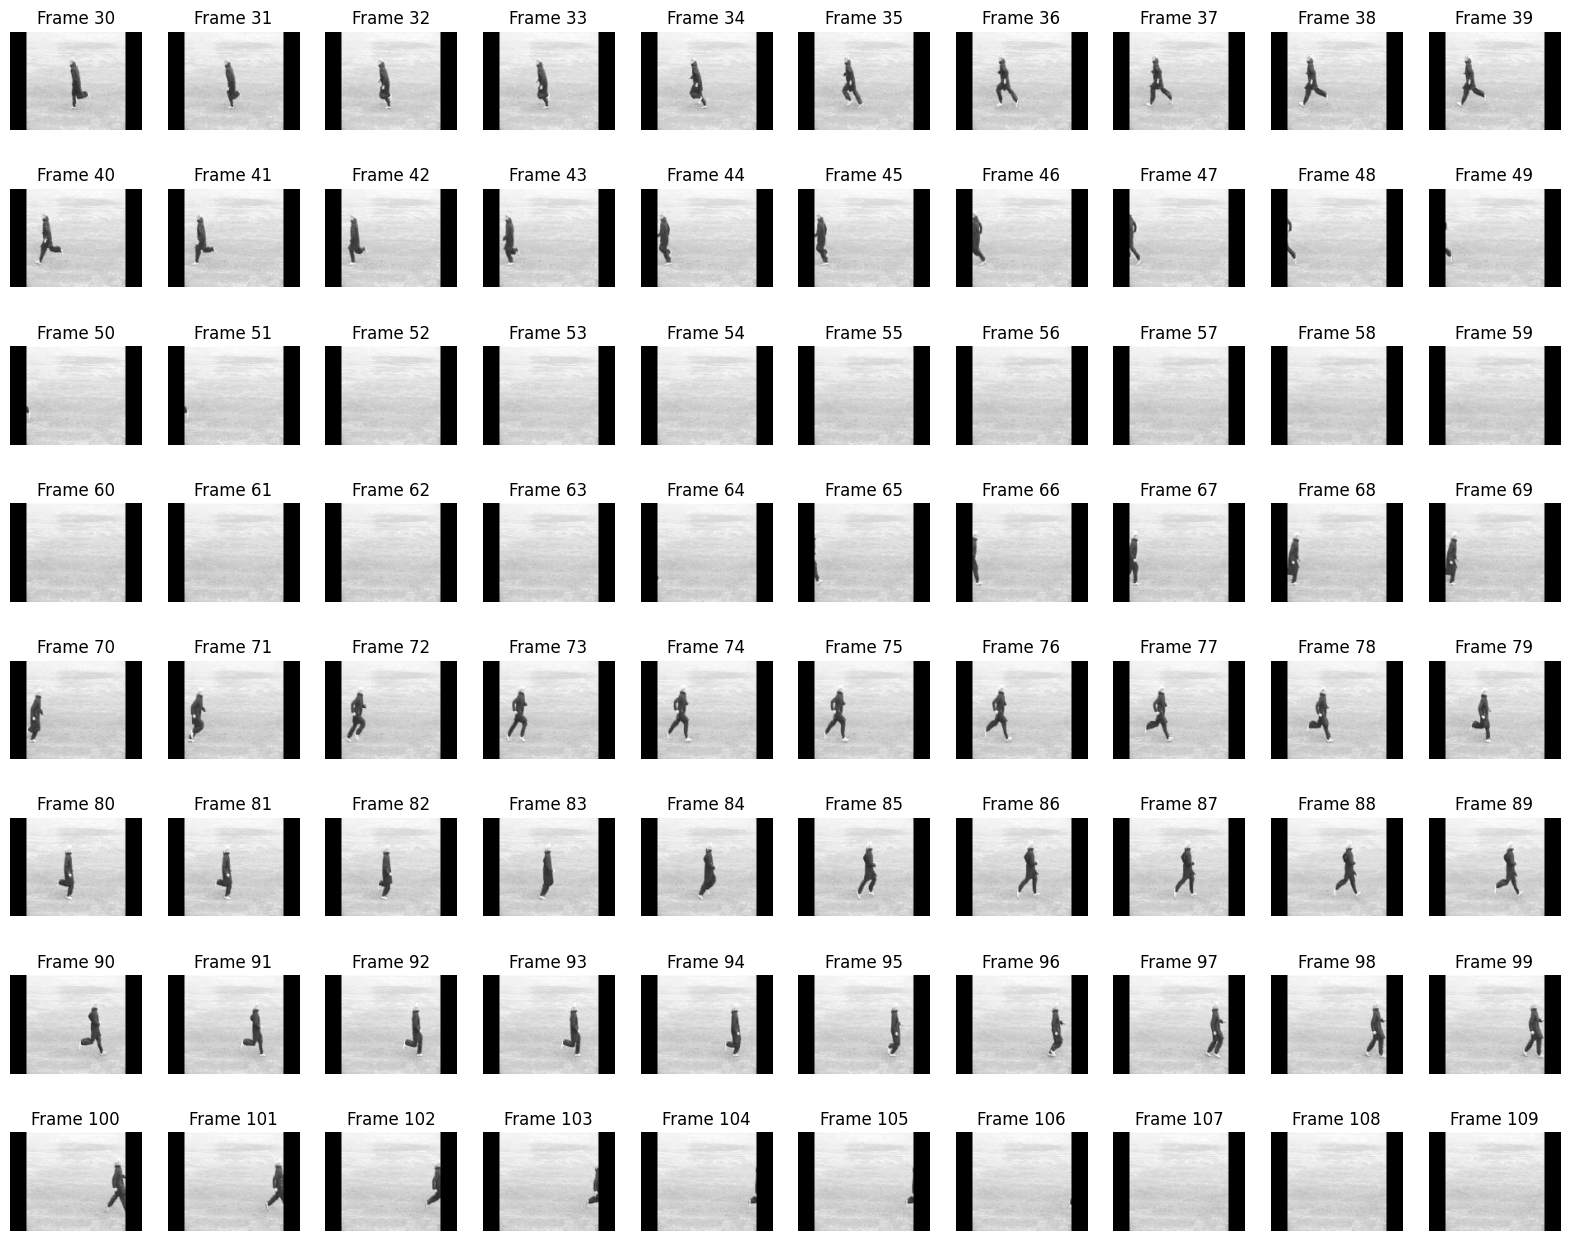

In [ ]:
def video_show(tensor, frames_per_row=10, start_frame=0, end_frame=20):
    # Вычисляем количество кадров для отображения
    total_frames = end_frame - start_frame
    rows = (total_frames // frames_per_row) + (1 if total_frames % frames_per_row != 0 else 0)

    # Создаем фигуру с нужным количеством строк и столбцов
    fig, axes = plt.subplots(rows, frames_per_row, figsize=(frames_per_row * 2, rows * 2))

    # Если в сетке только одна строка, нужно адаптировать axes
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    # Проходим по каждому кадру и отображаем
    for idx, ax in enumerate(axes.flat):
        frame_idx = start_frame + idx
        if frame_idx >= end_frame:
            break  # Прекращаем, если перебрали все кадры
        ax.imshow(np.squeeze(tensor[frame_idx]), cmap="gray")
        ax.set_title(f"Frame {frame_idx}")
        ax.axis("off")

    # Печатаем информацию и показываем фигуру
    print(f"Displaying frames from {start_frame + 1} to {end_frame}")
    plt.show()
video_show(x_train[0], frames_per_row=10, start_frame=30, end_frame=110)


In [ ]:

inp = x_train.copy()
inp = layers.Input(shape=(None, *inp.shape[2:]))

print(f"Размерность inp - {inp.shape}")

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(inp)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x) # waiting (None, None, channel, height, weight)
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
)

Размерность inp - (None, None, 120, 160, 1)


In [ ]:
model.summary()

In [ ]:

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 100
batch_size = 5


model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
1/1 [==============================] - 53s 53s/step - loss: 0.7106 - val_loss: 0.6854 - lr: 1.0000e-04
Epoch 2/20
1/1 [==============================] - 47s 47s/step - loss: 0.5607 - val_loss: 0.6815 - lr: 1.0000e-04
Epoch 3/20
1/1 [==============================] - 47s 47s/step - loss: 0.5104 - val_loss: 0.6778 - lr: 1.0000e-04
Epoch 4/20
1/1 [==============================] - 47s 47s/step - loss: 0.4807 - val_loss: 0.6741 - lr: 1.0000e-04
Epoch 5/20
1/1 [==============================] - 47s 47s/step - loss: 0.4532 - val_loss: 0.6707 - lr: 1.0000e-04
Epoch 6/20
1/1 [==============================] - 47s 47s/step - loss: 0.4336 - val_loss: 0.6676 - lr: 1.0000e-04
Epoch 7/20
1/1 [==============================] - 47s 47s/step - loss: 0.4184 - val_loss: 0.6647 - lr: 1.0000e-04
Epoch 8/20
1/1 [==============================] - 47s 47s/step - loss: 0.4059 - val_loss: 0.6621 - lr: 1.0000e-04
Epoch 9/20
1/1 [==============================] - 47s 47s/step - loss: 0.3945 - val_loss

Displaying frames from 1 to 10


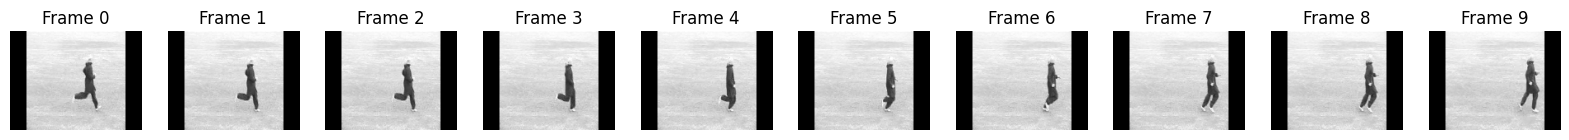

1/1 [==============================] - 1s 1s/step


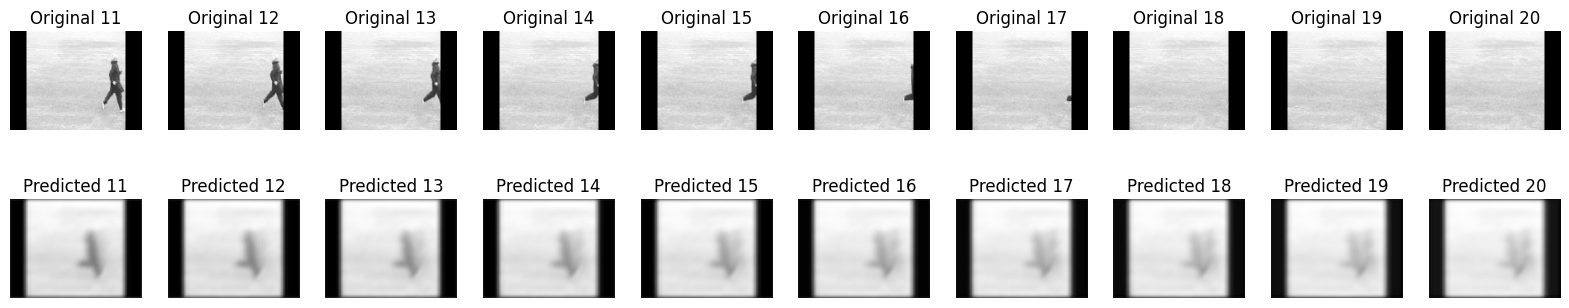

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Выбираем случайный пример из валидационного набора данных.
example = x_test[np.random.choice(range(len(x_test)), size=1)[0]]

# Разделим пример на первые 10 кадров и оставшиеся кадры для отображения.
frames = example[:10, ...]  # Первые 10 кадров для предсказания
original_frames = example[10:20, ...]  # Последующие 10 кадров для сравнения
video_show(frames, frames_per_row=10, start_frame=0, end_frame=10)
# Предсказываем новую последовательность из 10 кадров.
for _ in range(10):
    # Используем модель для предсказания следующего кадра.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))  # (1, frames, channels, height, width)
    new_prediction = np.squeeze(new_prediction, axis=0)  # Убираем измерение batch (None)

    # Берем последний предсказанный кадр и добавляем его к последовательности.
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)  # (1, channels, height, width)
    frames = np.concatenate((frames, predicted_frame), axis=0)  # Обновляем последовательность

# Создаем фигуру для отображения оригинальных и предсказанных кадров.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Отображаем оригинальные кадры.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Original {idx + 11}")
    ax.axis("off")

# Отображаем предсказанные кадры.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Predicted {idx + 11}")
    ax.axis("off")

# Отображаем фигуру.
plt.show()
